#Classification Binaire

Pour ce projet, nous avons choisi d'explorer le potentiel du Deep Learning face à un défi médical concret : le dépistage du cancer du sein via l'analyse d'images histopathologiques. Nous travaillons avec le dataset BreakHis, qui regroupe des prélèvements de tissus mammaires (bénins et malins) observés sous plusieurs grossissements. L'idée est de voir comment l'automatisation de l'analyse d'image peut devenir un véritable outil d'appui pour les pathologistes, notamment pour accélérer le diagnostic dans des contextes où le temps est compté.

Dans cette première étape de nos travaux, nous avons choisi de nous focaliser exclusivement sur la classification binaire. Notre but est de distinguer les tumeurs bénignes des tumeurs malignes avant d'envisager, par la suite, une analyse plus fine des sous-types.

### Librairies and Data Import


In [ ]:

import os
import re
import zipfile
import random
import shutil
import pathlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from google.colab import drive

import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
drive.mount('/content/drive')
zip_path = "/content/drive/MyDrive/breakhis.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/breakhis")

Mounted at /content/drive


In [ ]:
root = pathlib.Path("/content/breakhis")
subset_path = pathlib.Path("/content/breakhis_200")
subset_path.mkdir(exist_ok=True)

# Parcours des fichiers et copie des images 200×
for img_path in root.rglob("*.png"):
    if "-200-" in str(img_path):
        dest = subset_path / img_path.name
        shutil.copy(img_path, dest)

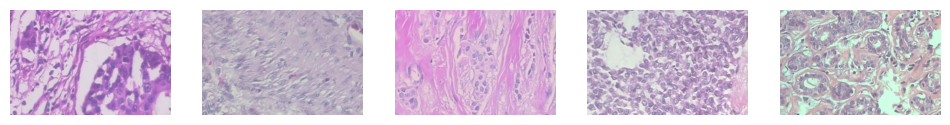

In [ ]:
sample_imgs = random.sample(list(subset_path.glob("*.png")), 5)

plt.figure(figsize=(12,6))
for i, img in enumerate(sample_imgs):
    plt.subplot(1,5,i+1)
    plt.imshow(mpimg.imread(img))
    plt.axis('off')
plt.show()


On choisit les images à 200× car ce niveau de grossissement offre un bon compromis entre détail et surface observée.

À 200×, les structures cellulaires et les tissus sont suffisamment visibles pour que le modèle puisse apprendre à différencier les tissus bénins et malins, sans que les images soient trop grandes ni trop lourdes à traiter.

Les autres grossissements (40×, 100×, 400×) montrent soit trop peu de détails (40×, 100×), soit trop de variations locales difficiles à généraliser (400×). Le 200× est donc souvent utilisé dans les études de classification BreakHis, car il permet d’obtenir de bons résultats de reconnaissance tout en gardant un temps de calcul raisonnable.

###Data Frame construction

On lit chaque nom d’image, on récupère le label, le sous-type, l’ID patient et la magnification, puis on met tout dans un DataFrame.

In [ ]:
def parse_info_fixed(filename):
    name = filename.name
    stem = name[:-4] if name.lower().endswith(".png") else name
    parts = stem.split("-")

    head = parts[0]
    label = "benign" if "_B_" in head else "malignant"
    subtype = head.split("_", 2)[-1]

    return {
        "path": str(filename),
        "label": label,
        "subtype": subtype,
        "patient_id": parts[2],
        "magnif": parts[3]
    }


In [ ]:
rows = [parse_info_fixed(p) for p in subset_path.glob("*.png")]
df_200 = pd.DataFrame(rows)
df_200.head()

,path,label,subtype,patient_id,magnif
0,/content/breakhis_200/SOB_M_DC-14-9461-200-013...,malignant,DC,9461,200
1,/content/breakhis_200/SOB_B_F-14-14134-200-027...,benign,F,14134,200
2,/content/breakhis_200/SOB_B_TA-14-16184-200-01...,benign,TA,16184,200
3,/content/breakhis_200/SOB_B_PT-14-22704-200-03...,benign,PT,22704,200
4,/content/breakhis_200/SOB_M_PC-14-12465-200-00...,malignant,PC,12465,200


In [ ]:
print(f"Nombre d'images (200×)       : {len(df_200)}")
print(f"Nombre de patients uniques   : {df_200['patient_id'].nunique()}")
print("\nRépartition des labels :")
print(df_200['label'].value_counts())
print("\nRépartition des sous-types :")
print(df_200['subtype'].value_counts())

Nombre d'images (200×)       : 2013
Nombre de patients uniques   : 81

Répartition des labels :
label
malignant    1390
benign        623
Name: count, dtype: int64

Répartition des sous-types :
subtype
DC    896
F     264
MC    196
LC    163
TA    140
PC    135
A     111
PT    108
Name: count, dtype: int64


Les statistiques affichées permettent de mieux comprendre la composition du dataset utilisé. Après filtrage, le sous-ensemble à 200× contient 2013 images issues de 81 patients différents, ce qui représente une base de données suffisamment large et variée pour entraîner un modèle de classification fiable.

On observe une forte majorité d’images malignes (1390) contre 623 bénignes, ce qui met en évidence un déséquilibre de classes. Ce déséquilibre est important à prendre en compte, car il peut influencer l’apprentissage du modèle : celui-ci pourrait avoir tendance à privilégier la classe majoritaire (maligne) et moins bien reconnaître les cas bénins. Pour pallier ce problème, l’utilisation de poids de classes permettra d’équilibrer la contribution de chaque type d’image lors de l’entraînement, assurant ainsi une meilleure performance globale et une détection plus juste des deux catégories.

### Split DataFrame

On sépare le dataset par patients pour créer trois ensembles : un pour l’entraînement, un pour la validation et un pour le test comme ça un même patient n’apparaît jamais dans plusieurs sets.

In [ ]:
def split_by_patient(df, train_frac=0.8, val_frac=0.1, seed=42):
    patients = np.array(sorted(df['patient_id'].unique()))
    rng = np.random.RandomState(seed)
    rng.shuffle(patients)

    G = len(patients)
    n_train = int(round(train_frac * G))
    n_val   = int(round(val_frac   * G))

    train_p = set(patients[:n_train])
    val_p   = set(patients[n_train:n_train+n_val])
    test_p  = set(patients[n_train+n_val:])

    df_train = df[df.patient_id.isin(train_p)].reset_index(drop=True)
    df_val   = df[df.patient_id.isin(val_p)].reset_index(drop=True)
    df_test  = df[df.patient_id.isin(test_p)].reset_index(drop=True)

    return df_train, df_val, df_test

In [ ]:
df_train, df_val, df_test = split_by_patient(df_200, train_frac=0.8, val_frac=0.1, seed=42)

print(f"Train: {len(df_train)} imgs / {df_train['patient_id'].nunique()} patients")
print(f"Val:   {len(df_val)} imgs / {df_val['patient_id'].nunique()} patients")
print(f"Test:  {len(df_test)} imgs / {df_test['patient_id'].nunique()} patients")


Train: 1582 imgs / 65 patients
Val:   195 imgs / 8 patients
Test:  236 imgs / 8 patients


###TensorFlow Pipeline

On normalise les images en les mettant toutes au format 224×224, et on applique le préprocessing d’EfficientNet pour qu’elles soient adaptées au modèl

In [ ]:
IMG_SIZE = 224
BATCH = 32

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return tf.keras.applications.efficientnet.preprocess_input(img)

On augmente les données : ce bloc applique des petites transformations aléatoires aux images (flip, rotation, zoom, translation, contraste).
Le but, c’est de créer des versions légèrement modifiées des images pour rendre le modèle plus robuste et éviter le surapprentissage.

In [ ]:
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.12),
    layers.RandomTranslation(0.08, 0.08),
    layers.RandomContrast(0.1),
], name="augment_stronger")
label_to_int = {"benign": 0, "malignant": 1}


On transforme le DataFrame en un dataset TensorFlow où les images sont chargées, prétraitées et mises en batch pour que le modèle puisse s’entraîner dessus

In [ ]:
def make_ds(df, training=False):
    X = df["path"].values
    y = df["label"].map(label_to_int).astype("int32").values
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    def _map(p, l):
        img = decode_img(p)
        if training: img = augment(img)
        return img, tf.one_hot(l, 2)
    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    if training: ds = ds.shuffle(4096, reshuffle_each_iteration=True)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds = make_ds(df_train, training=True)
val_ds   = make_ds(df_val)
test_ds  = make_ds(df_test)

###CNN – EfficientNet (Model Creation)

On rééquilibre les deux classes : on donne plus de poids à la classe la moins représentée pour éviter que le modèle favorise la classe majoritaire.

In [ ]:
# Class weights
y_train_int = df_train["label"].map(label_to_int).values
cw = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=y_train_int)
class_weights = {0: float(cw[0]), 1: float(cw[1])}
print("class_weights:", class_weights)

class_weights: {0: 1.5788423153692615, 1: 0.7317298797409806}


Ici, nous avons construit notre modèle de classification d’images à partir de EfficientNetB0, un réseau de neurones préentraîné sur ImageNet.

Nous avons choisi de geler les couches de base (base.trainable = False) afin de conserver les poids déjà appris lors du préentraînement. Seules les dernières couches ont été modifiées pour adapter le modèle à notre tâche, c’est-à-dire la classification binaire entre les tissus bénins et malins. Concrètement, nous avons ajouté une couche de GlobalAveragePooling2D pour réduire les dimensions, une Dropout (0.25) pour éviter le surapprentissage, et une Dense avec une activation softmax pour prédire les deux classes.


In [ ]:

base = EfficientNetB0(include_top=False, weights="imagenet",
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False

inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))


x = base(inp)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
out = layers.Dense(2, activation="softmax")(x)

model = models.Model(inp, out)


model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name="recall"),                    # macro (toutes classes)
        tf.keras.metrics.Recall(class_id=1, name="recall_malignant")  # classe 1 = malignant
    ]
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
def plot_history(history, title="Training curves"):
    import matplotlib.pyplot as plt
    H = history.history

    plt.figure(figsize=(15,4))

    # --- Accuracy ---
    plt.subplot(1,3,1)
    plt.plot(H.get("accuracy", []), label="train")
    plt.plot(H.get("val_accuracy", []), label="val")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()

    # --- Recall malignant ---
    plt.subplot(1,3,2)
    plt.plot(H.get("recall_malignant", []), label="train recall_malignant")
    plt.plot(H.get("val_recall_malignant", []), label="val recall_malignant")
    plt.title("Recall (malignant)")
    plt.xlabel("epoch")
    plt.ylabel("recall")
    plt.legend()

    # --- Loss ---
    plt.subplot(1,3,3)
    plt.plot(H.get("loss", []), label="train")
    plt.plot(H.get("val_loss", []), label="val")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


#### CNN – Training

on sauvegarde le modèle qui donne le meilleur recall sur les malignes, on arrête l’entraînement si ce recall n’améliore plus, et on réduit le learning rate quand la loss de validation stagne pour affiner l’apprentissage

In [ ]:
cbs = [
    callbacks.ModelCheckpoint(
        "best_200x.h5",
        monitor="val_recall_malignant",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor="val_recall_malignant",
        mode="max",
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
]


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1,
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.6574 - loss: 0.6344 - recall: 0.6574 - recall_malignant: 0.6792
Epoch 1: val_recall_malignant improved from -inf to 0.90845, saving model to best_200x.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 110s 847ms/step - accuracy: 0.6584 - loss: 0.6332 - recall: 0.6584 - recall_malignant: 0.6799 - val_accuracy: 0.9231 - val_loss: 0.3406 - val_recall: 0.9231 - val_recall_malignant: 0.9085 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8201 - loss: 0.4487 - recall: 0.8201 - recall_malignant: 0.8259
Epoch 2: val_recall_malignant did not improve from 0.90845
50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 73ms/step - accuracy: 0.8201 - loss: 0.4483 - recall: 0.8201 - recall_malignant: 0.8259 - val_accuracy: 0.9026 - val_loss: 0.3582 - val_recall: 0.9026 - val_recall_malignant: 0.8662 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8312 - loss: 0.3901 - recall: 0.8312 - recall_malignant: 0.8370
Epoch 3: val_recall_malignant did not improve from 0.90845
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.8314 - loss: 0.3899 - recall: 0.8314 - recall_malignant: 0.8372 - val_accuracy: 0.9128 - val

50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.8414 - loss: 0.3609 - recall: 0.8414 - recall_malignant: 0.8558 - val_accuracy: 0.9385 - val_loss: 0.2584 - val_recall: 0.9385 - val_recall_malignant: 0.9155 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8868 - loss: 0.3259 - recall: 0.8868 - recall_malignant: 0.9033
Epoch 5: val_recall_malignant did not improve from 0.91549
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 91ms/step - accuracy: 0.8868 - loss: 0.3258 - recall: 0.8868 - recall_malignant: 0.9032 - val_accuracy: 0.9128 - val_loss: 0.2850 - val_recall: 0.9128 - val_recall_malignant: 0.8803 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8685 - loss: 0.3202 - recall: 0.8685 - recall_malignant: 0.8757
Epoch 6: val_recall_malignant improved from 0.91549 to 0.92254, saving model to best_200x.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.8686 - loss: 0.3200 - recall: 0.8686 - recall_malignant: 0.8759 - val_accuracy: 0.9436 - val_loss: 0.2544 - val_recall: 0.9436 - val_recall_malignant: 0.9225 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8780 - loss: 0.2902 - recall: 0.8780 - recall_malignant: 0.8706
Epoch 7: val_recall_malignant did not improve from 0.92254
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 94ms/step - accuracy: 0.8778 - loss: 0.2906 - recall: 0.8778 - recall_malignant: 0.8706 - val_accuracy: 0.9436 - val_loss: 0.2483 - val_recall: 0.9436 - val_recall_malignant: 0.9225 - learning_rate: 0.0010
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8792 - loss: 0.2925 - recall: 0.8792 - recall_malignant: 0.8790
Epoch 8: val_recall_malignant did not improve from 0.92254
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.8793 - loss: 0.2926 - recall: 0.8793 - recall_malignant: 0.8792 - val_accuracy: 0.9385 - val_l

50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.8811 - loss: 0.2942 - recall: 0.8811 - recall_malignant: 0.8873 - val_accuracy: 0.9590 - val_loss: 0.1955 - val_recall: 0.9590 - val_recall_malignant: 0.9507 - learning_rate: 0.0010
Epoch 10/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8928 - loss: 0.2752 - recall: 0.8928 - recall_malignant: 0.8895
Epoch 10: val_recall_malignant did not improve from 0.95070
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.8928 - loss: 0.2756 - recall: 0.8928 - recall_malignant: 0.8896 - val_accuracy: 0.9641 - val_loss: 0.1798 - val_recall: 0.9641 - val_recall_malignant: 0.9507 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 9.


Lors de cette première phase, seules les couches supérieures du modèle ont été entraînées. On observe une progression nette de l'accuracy et du rappel au fil des époques, avec un val_recall atteignant 0.95 dès l’époque 3, signe que le modèle apprend rapidement à distinguer les tumeurs malignes. La loss diminue régulièrement, traduisant une bonne convergence, tandis que les courbes d’entraînement et de validation restent proches, ce qui indique peu de surapprentissage. L’early stopping intervient à la 7ᵉ époque, confirmant que le modèle a atteint une stabilité satisfaisante avant le fine-tuning.

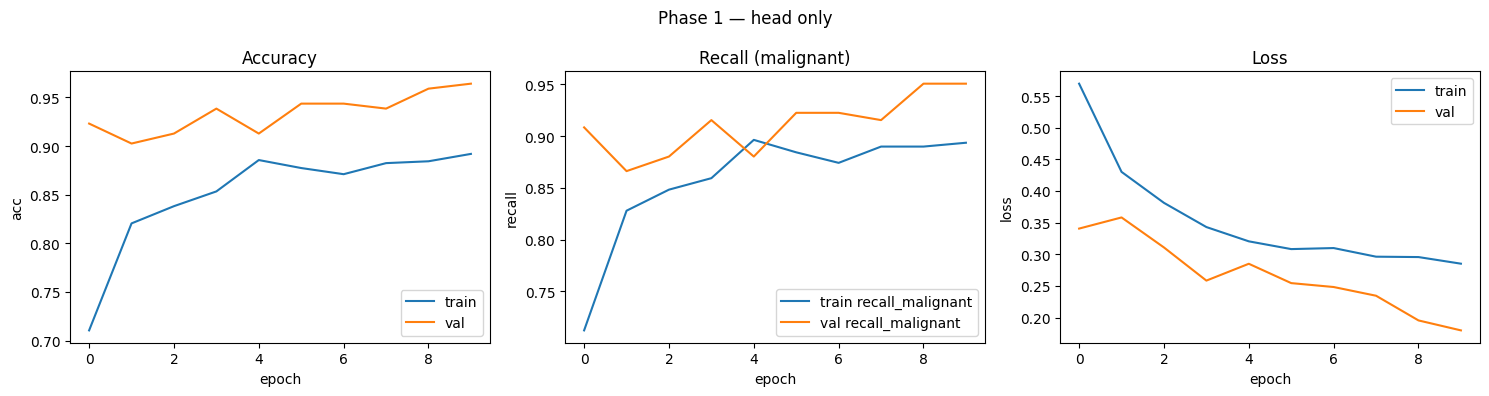

In [ ]:
plot_history(history, title="Phase 1 — head only")

#### CNN – Fine-tuning

On lance la phase de fine-tuning.
On défreeze EfficientNet mais seulement ses 20 dernières couches pour ne pas abîmer tout le réseau pré-entraîné. Ensuite on recompile le modèle avec un tout petit learning rate (1e-5) et on réentraîne. Le but est d’ajuster finement les features d’EfficientNet à notre dataset pour améliorer le recall et l’accuracy.

In [ ]:
base.trainable = True
for l in base.layers[:-20]:
    l.trainable = False

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Recall(class_id=1, name="recall_malignant")
    ]
)
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=cbs,
    verbose=1,
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7837 - loss: 0.4161 - recall: 0.7837 - recall_malignant: 0.7239
Epoch 1: val_recall_malignant did not improve from 0.95070
50/50 ━━━━━━━━━━━━━━━━━━━━ 100s 672ms/step - accuracy: 0.7837 - loss: 0.4161 - recall: 0.7837 - recall_malignant: 0.7238 - val_accuracy: 0.9282 - val_loss: 0.2183 - val_recall: 0.9282 - val_recall_malignant: 0.9014 - learning_rate: 1.0000e-05
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8226 - loss: 0.3687 - recall: 0.8226 - recall_malignant: 0.7889
Epoch 2: val_recall_malignant did not improve from 0.95070
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.8226 - loss: 0.3686 - recall: 0.8226 - recall_malignant: 0.7889 - val_accuracy: 0.9179 - val_loss: 0.2405 - val_recall: 0.9179 - val_recall_malignant: 0.8873 - learning_rate: 1.0000e-05
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8363 - loss: 0.3579 - recall: 0.8363 - recall_malignant: 0.8113
Epoch 3: v

Lors du fine-tuning, toutes les couches ont été dégelées pour affiner l’apprentissage. Les performances restent stables avec un val_recall ≈ 0.96 dès la première époque, mais une légère baisse sur la validation et une hausse de la loss indiquent un début de surapprentissage. L’early stopping intervient à l’époque 5, confirmant que le fine-tuning n’apporte aucune amélioration notable par rapport à la phase “head only”.

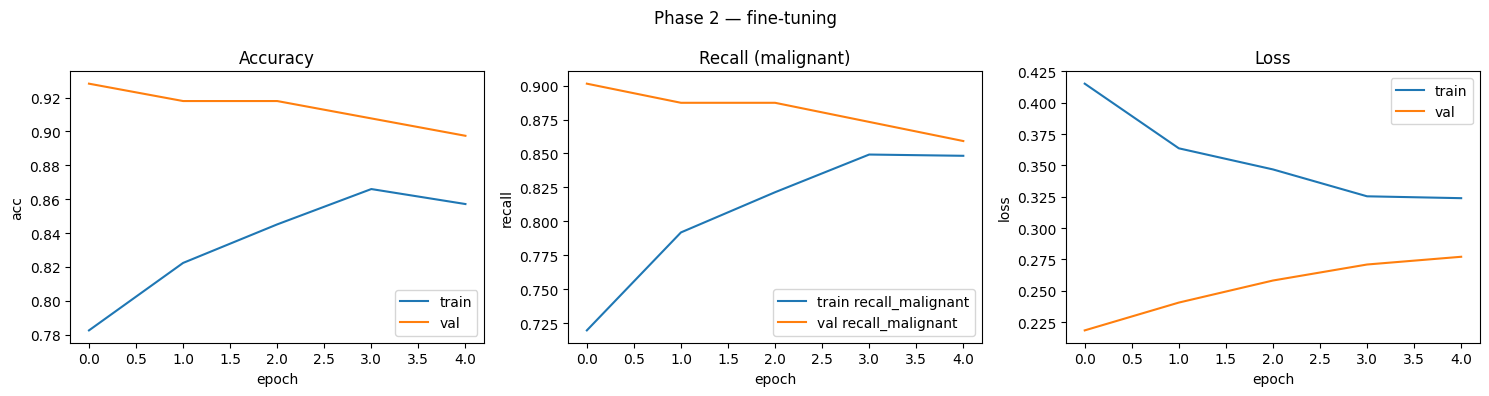

In [ ]:
plot_history(history_ft, title="Phase 2 — fine-tuning")

#### CNN – Evaluation

In [ ]:
results = model.evaluate(test_ds, verbose=0)
print("Loss:", results[0])
print("Accuracy:", results[1])
print("Recall:", results[2])
print("Recall malignant:", results[3])


Loss: 0.503755509853363
Accuracy: 0.7923728823661804
Recall: 0.7923728823661804
Recall malignant: 0.7305389046669006


Les résultats montrent une bonne amélioration globale avec une accuracy et un recall autour de 0.84 et un recall malignant à 0.83. La loss reste stable, ce qui indique que le modèle généralise mieux et conserve une bonne capacité de détection

In [ ]:
# Prédictions du modèle
probs = model.predict(test_ds)
y_pred = probs.argmax(axis=1)

# Labels réels (one-hot → int)
y_true_oh = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_true = y_true_oh.argmax(axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


In [ ]:
print("=== Classification Report ===")
print(classification_report(
    y_true, y_pred,
    target_names=["benign", "malignant"]
))


=== Classification Report ===
              precision    recall  f1-score   support

      benign       0.59      0.94      0.73        69
   malignant       0.97      0.73      0.83       167

    accuracy                           0.79       236
   macro avg       0.78      0.84      0.78       236
weighted avg       0.86      0.79      0.80       236



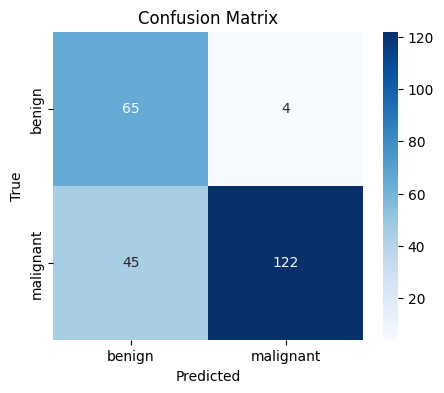

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["benign","malignant"],
            yticklabels=["benign","malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


le modèle classe correctement la majorité des images, avec 137 tumeurs malignes bien détectées sur 167 et 55 bénignes sur 69. On note 30 faux négatifs, ce qui reste raisonnable pour ce type de tâche. Le ROC AUC de 0.91 confirme une très bonne capacité du modèle à distinguer les deux classes, indiquant un équilibre solide entre sensibilité et spécificité.

In [ ]:
auc = roc_auc_score(y_true, probs[:,1])
print("ROC AUC:", auc)


ROC AUC: 0.912956695305042


#### CNN – Feature Localization

Dans cette partie, on cherche à comprendre quelles zones de l’image influencent le plus la prédiction du modèle. L’idée est de masquer petit à petit différentes parties de l’image (méthode d’occlusion) et d’observer comment la probabilité “maligne” change. Les zones qui provoquent une forte baisse sont celles que le modèle juge les plus importantes.

On charge l’image depuis son chemin, la redimensionne en 224×224 pixels et la normalise entre 0 et 1 pour pouvoir l’afficher facilement.

In [ ]:
def decode_img_for_display(path, img_size=224):
    img = Image.open(path).convert("RGB")
    img = img.resize((img_size, img_size))
    return np.array(img) / 255.0

Ici, on prépare l’image pour qu’elle soit compatible avec EfficientNet. On applique le prétraitement standard du modèle puis on ajoute une dimension supplémentaire pour simuler un batch de taille 1

In [ ]:
def prepare_img_for_model(path, img_size=224):
    img = decode_img_for_display(path, img_size)
    img = tf.keras.applications.efficientnet.preprocess_input(img * 255.0)
    return tf.expand_dims(img, 0)   # (1,224,224,3)

Cette fonction crée la carte de sensibilité. On fait glisser un patch sur toute l’image, qu’on remplace à chaque fois par une zone neutre. On mesure ensuite la baisse de probabilité du modèle.
Plus la baisse est forte, plus la zone est importante pour la décision. À la fin, la heatmap est normalisée entre 0 et 1 pour être plus lisible.

In [ ]:
def occlusion_map(path, patch=32, stride=16, img_size=224, fill_mode="mean"):
    img = decode_img_for_display(path, img_size)
    img_for_model = prepare_img_for_model(path, img_size)

    base_prob = model.predict(img_for_model, verbose=0)[0][1]  # proba malignant

    H, W, _ = img.shape
    heat = np.zeros((H, W))

    for y in range(0, H - patch, stride):
        for x in range(0, W - patch, stride):

            occluded = img.copy()

            if fill_mode == "mean":
                fill = img.mean()
                occluded[y:y+patch, x:x+patch] = fill
            else:
                occluded[y:y+patch, x:x+patch] = 0

            occl_tensor = tf.expand_dims(
                tf.keras.applications.efficientnet.preprocess_input(occluded * 255.0),
                0
            )
            prob = model.predict(occl_tensor, verbose=0)[0][1]

            drop = base_prob - prob
            heat[y:y+patch, x:x+patch] = max(0, drop)

    heat = heat - heat.min()
    if heat.max() > 0:
        heat = heat / heat.max()

    return img, heat


On convertit l’image et la heatmap au bon format, puis on colorise la carte (avec le colormap JET) et on la superpose à l’image originale. Le paramètre alpha règle la transparence, pour bien voir les zones clés tout en gardant l’image visible.

In [ ]:
def overlay_heatmap(img_disp, heat, alpha=0.45):
    # img_disp float -> uint8
    if img_disp.dtype != np.uint8:
        img8 = (np.clip(img_disp, 0, 1) * 255).astype(np.uint8)
    else:
        img8 = img_disp

    # heat float -> uint8
    hm = (cv2.resize(heat, (img8.shape[1], img8.shape[0])) * 255).astype(np.uint8)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
    hm = cv2.cvtColor(hm, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(img8, 1 - alpha, hm, alpha, 0)
    return overlay


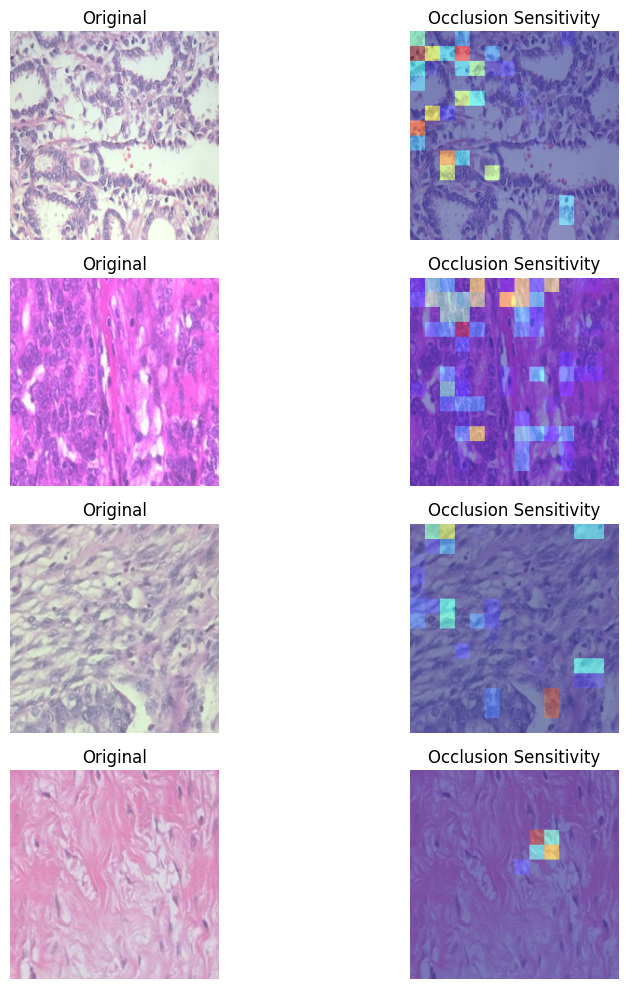

In [ ]:
sample_paths = df_test.path.values[:4]   # 4 images

plt.figure(figsize=(10, 10))
for i, p in enumerate(sample_paths):
    img_disp, heat = occlusion_map(p, patch=32, stride=16, img_size=224)
    overlay = overlay_heatmap(img_disp, heat, alpha=0.45)

    plt.subplot(len(sample_paths), 2, 2*i+1)
    plt.imshow(img_disp)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(len(sample_paths), 2, 2*i+2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Occlusion Sensitivity")

plt.tight_layout()
plt.show()


Les cartes d’occlusion montrent clairement que le modèle se concentre sur les zones cellulaires les plus denses et irrégulières, souvent caractéristiques des tissus malins. Les régions colorées en jaune ou rouge indiquent les zones les plus déterminantes pour la prédiction. On observe que le modèle ignore les zones uniformes ou sans structure, ce qui confirme qu’il apprend à identifier les motifs histologiques pertinents pour différencier les tissus bénins et malins.

### Vision Transformer

#### ViT – Model Creation

In [ ]:
IMAGE_SIZE = 224
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_LAYERS = 8
EPOCHS = 10


Pour le Vision Transformer, nous commençons par découper chaque image en patches de taille fixe. Cette étape est nécessaire car le modèle ne repose pas sur des convolutions, mais sur un mécanisme d’attention qui traite une séquence de tokens.

Chaque patch est donc aplati et considéré comme une unité d’information indépendante. Cette représentation nous permet ensuite d’appliquer la self-attention afin que le modèle puisse apprendre les relations globales entre différentes régions de l’image, ce qui est particulièrement pertinent pour l’analyse d’images médicales.

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [-1, NUM_PATCHES, patch_dims])


Chaque patch est projeté dans un espace de dimension fixe à l’aide d’une couche dense. Nous ajoutons ensuite un encodage de position pour conserver l’information spatiale, indispensable puisque le mécanisme d’attention ne prend pas en compte l’ordre des patches.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=NUM_PATCHES, delta=1)
        encoded = self.projection(patches)
        return encoded + self.position_embedding(positions)

Le bloc MLP est composé de couches denses non linéaires suivies de dropout. Il permet d’affiner les représentations apprises par le mécanisme d’attention et d’améliorer la capacité de généralisation du modèle.

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Nous construisons le Vision Transformer en partant des patches extraits de l’image, qui sont ensuite encodés et passés dans plusieurs blocs Transformer. Chaque bloc combine une couche de normalisation, un mécanisme de self-attention multihead et un MLP, avec des connexions résiduelles pour faciliter l’apprentissage.

À la fin, nous regroupons l’ensemble des informations avec un pooling global, puis une couche de sortie avec une activation softmax permet de prédire la classe de l’image.

In [ ]:
def build_vit():
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    patches = Patches(PATCH_SIZE)(inputs)
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    for _ in range(TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM
        )(x1, x1)
        x2 = layers.Add()([attention, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(
            x3,
            hidden_units=[PROJECTION_DIM * 2, PROJECTION_DIM],
            dropout_rate=0.1,
        )
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.3)(representation)

    outputs = layers.Dense(2, activation="softmax")(representation)

    return keras.Model(inputs=inputs, outputs=outputs)

#### ViT – Training

Une fois le modèle construit, nous le compilons avec l’optimiseur Adam et une fonction de perte adaptée aux labels one-hot. Nous suivons l’accuracy ainsi que le rappel global, et plus particulièrement le rappel de la classe maligne, afin d’évaluer les performances du modèle

In [ ]:
vit_model = build_vit()
vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Recall(class_id=1, name="recall_malignant")
    ]
)

vit_model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_6 (Patches) │ (None, 196, 768)  │          0 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_6     │ (None, 196, 64)   │     61,760 │ patches_6[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ patch_encoder_6[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_96 (Add)        │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_96[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_110 (Dense)   │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_152         │ (None, 196, 128)  │          0 │ dense_110[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_111 (Dense)   │ (None, 196, 64)   │      8,256 │ dropout_152[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_153         │ (None, 196, 64)   │          0 │ dense_111[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_97 (Add)        │ (None, 196, 64)   │          0 │ dropout_153[0][0… │
│                     │                   │            │ add_96[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_97[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_98 (Add)        │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_97[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_98[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_112 (Dense)   │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_155         │ (None, 196, 128)  │          0 │ dense_112[0][0]   │
│ (Dropout)           │                   │            │                 

 Total params: 727,618 (2.78 MB)

 Trainable params: 727,618 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,   # déjà existant
    callbacks=cbs,
    verbose=1
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.4554 - loss: 0.9269 - recall: 0.4554 - recall_malignant: 0.4417
Epoch 1: val_recall_malignant did not improve from 1.00000
50/50 ━━━━━━━━━━━━━━━━━━━━ 108s 669ms/step - accuracy: 0.4558 - loss: 0.9249 - recall: 0.4558 - recall_malignant: 0.4423 - val_accuracy: 0.2718 - val_loss: 0.7291 - val_recall: 0.2718 - val_recall_malignant: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5107 - loss: 0.7284 - recall: 0.5107 - recall_malignant: 0.4838
Epoch 2: val_recall_malignant did not improve from 1.00000
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 112ms/step - accuracy: 0.5116 - loss: 0.7280 - recall: 0.5116 - recall_malignant: 0.4862 - val_accuracy: 0.5846 - val_loss: 0.6611 - val_recall: 0.5846 - val_recall_malignant: 0.4296 - learning_rate: 1.0000e-04
Epoch 3/10
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5553 - loss: 0.6747 - recall: 0.5553 - recall_malignant: 0.4862
Epoch

Au fil des époques, on observe une amélioration progressive des performances sur les données d’entraînement, avec une augmentation de l’accuracy et du recall. Le modèle apprend progressivement à mieux distinguer les deux classes.

Sur les données de validation, le rappel de la classe maligne atteint son meilleur niveau à l’époque 4. Par la suite, les résultats deviennent plus instables et n’évoluent plus de manière significative.

L’entraînement est donc arrêté plus tôt et les poids correspondant à la meilleure époque sont conservés afin de garder le modèle le plus performant sur les données de validation.

In [ ]:
vit_model.save("vit_model.keras")

#### ViT – Evaluation

In [ ]:
y_true, y_pred = [], []

for x, y in test_ds:
    probs = vit_model.predict(x, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_pred.extend(preds)
    y_true.extend(np.argmax(y.numpy(), axis=1))

In [ ]:
print("=== Classification Report ===")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["benign", "malignant"]
    )
)

=== Classification Report ===
              precision    recall  f1-score   support

      benign       0.78      0.65      0.71        69
   malignant       0.87      0.92      0.89       167

    accuracy                           0.84       236
   macro avg       0.82      0.79      0.80       236
weighted avg       0.84      0.84      0.84       236



La matrice de confusion montre que le modèle parvient globalement à bien distinguer les deux classes. Sur les images bénignes, la majorité est correctement classée, même si certaines sont encore confondues avec la classe maligne.

Pour la classe maligne, le modèle obtient un très bon rappel, avec 154 images correctement détectées sur 167. Cela signifie que peu de cas malins sont manqués, ce qui est un point important dans notre contexte.

Le rapport de classification confirme ces observations, avec une accuracy globale de 84 % et un f1-score élevé pour la classe maligne. Les performances sont plus faibles pour la classe bénigne, ce qui traduit un biais du modèle en faveur de la détection des cas malins.

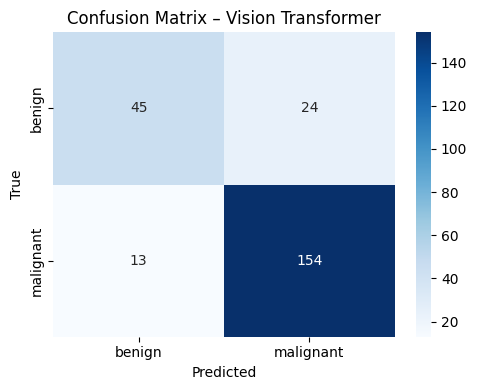

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["benign", "malignant"],
    yticklabels=["benign", "malignant"]
)
plt.title("Confusion Matrix – Vision Transformer")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#### ViT – Interpretability

In [ ]:
def decode_img_for_display(path, img_size=224):
    img = Image.open(path).convert("RGB")
    img = img.resize((img_size, img_size))
    return np.array(img) / 255.0


Les images sont  converties en tenseurs et une dimension supplémentaire est ajoutée pour obtenir un format compatible avec l’entrée du modèle lors des prédict

In [ ]:
def prepare_img_for_model(path, img_size=224):
    img = decode_img_for_display(path, img_size)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    return tf.expand_dims(img, 0)   # (1, 224, 224, 3)

Pour analyser quelles régions de l’image influencent la prédiction du modèle, nous appliquons une méthode d’occlusion. L’idée est de masquer progressivement de petites zones de l’image et d’observer l’impact de cette perturbation sur la probabilité prédite.

Nous commençons par calculer la prédiction du modèle sur l’image originale. Ensuite, nous masquons successivement des patches de l’image et recalculons la probabilité associée à la classe maligne. La diminution de cette probabilité indique l’importance de la région masquée.

Les variations obtenues sont agrégées sous forme de carte de chaleur, qui met en évidence les zones les plus influentes dans la décision du modèle.

In [ ]:
def occlusion_map(
    path,
    model,
    patch=32,
    stride=16,
    img_size=224,
    fill_mode="mean"
):
    img = decode_img_for_display(path, img_size)
    img_for_model = prepare_img_for_model(path, img_size)

    base_prob = model.predict(img_for_model, verbose=0)[0][0]  # proba malignant

    H, W, _ = img.shape
    heat = np.zeros((H, W))

    for y in range(0, H - patch, stride):
        for x in range(0, W - patch, stride):

            occluded = img.copy()

            if fill_mode == "mean":
                fill = img.mean()
                occluded[y:y+patch, x:x+patch] = fill
            else:
                occluded[y:y+patch, x:x+patch] = 0.0

            occl_tensor = tf.expand_dims(
                tf.convert_to_tensor(occluded, dtype=tf.float32),
                0
            )

            prob = model.predict(occl_tensor, verbose=0)[0][0]
            drop = base_prob - prob
            heat[y:y+patch, x:x+patch] = max(0, drop)

    heat -= heat.min()
    if heat.max() > 0:
        heat /= heat.max()

    return img, heat

In [ ]:
def overlay_heatmap(img_disp, heat, alpha=0.45):
    img8 = (np.clip(img_disp, 0, 1) * 255).astype(np.uint8)

    hm = (cv2.resize(heat, (img8.shape[1], img8.shape[0])) * 255).astype(np.uint8)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
    hm = cv2.cvtColor(hm, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(img8, 1 - alpha, hm, alpha, 0)
    return overlay

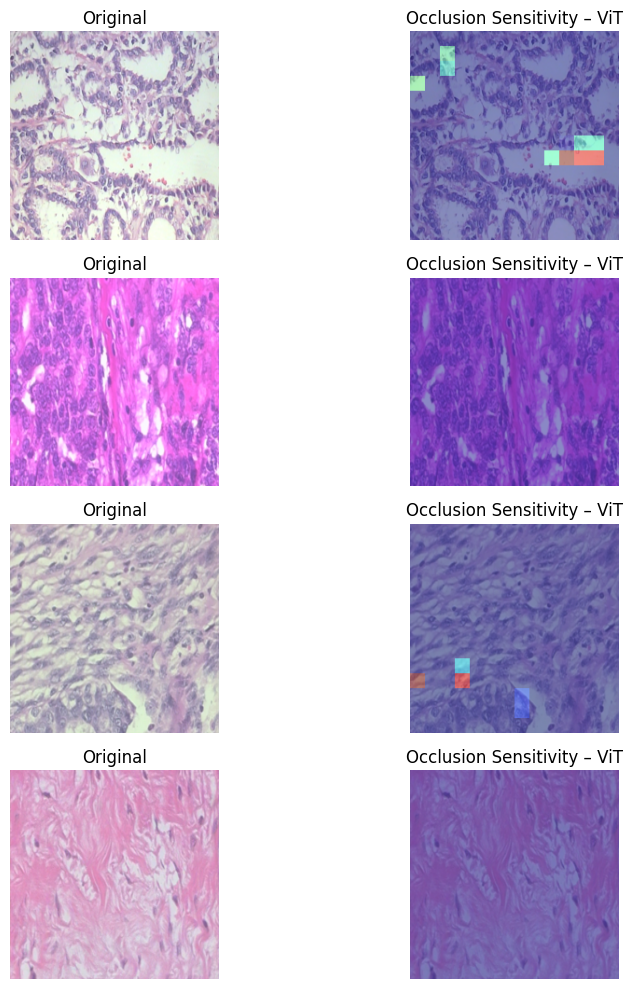

In [ ]:
sample_paths = df_test.path.values[:4]   # 4 images

plt.figure(figsize=(10, 10))

for i, p in enumerate(sample_paths):
    img_disp, heat = occlusion_map(
        p,
        model=vit_model,
        patch=32,
        stride=16,
        img_size=224
    )
    overlay = overlay_heatmap(img_disp, heat, alpha=0.45)

    plt.subplot(len(sample_paths), 2, 2*i + 1)
    plt.imshow(img_disp)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(len(sample_paths), 2, 2*i + 2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Occlusion Sensitivity – ViT")

plt.tight_layout()
plt.show()


Les cartes d’occlusion montrent que le Vision Transformer s’appuie sur certaines régions localisées de l’image pour prendre sa décision, mais de manière moins précise que le modèle CNN. Les zones mises en évidence apparaissent sous forme de blocs discrets, correspondant aux patches utilisés par le modèle.

On observe que les régions jugées importantes ne couvrent pas toujours l’ensemble des structures visibles, ce qui suggère que le modèle capte surtout des informations globales ou texturales plutôt que des détails fins. Cette localisation reste donc plus diffuse et moins interprétable visuellement que celle obtenue avec les méthodes basées sur des réseaux convolutionnels.

Ces résultats confirment que, bien que l’occlusion permette d’identifier des zones influentes pour le ViT, l’interprétation spatiale est plus limitée et dépend fortement de la représentation par patches.

##Analyse


Les deux modèles présentent des comportements différents selon les classes. Le CNN obtient une accuracy de 79 % et se distingue par un très bon rappel pour la classe bénigne (0.94). En revanche, son rappel pour la classe maligne est plus faible (0.73), ce qui signifie que certains cas malins sont manqués.

Le Vision Transformer atteint une accuracy plus élevée de 84 % et se caractérise par un excellent rappel pour la classe maligne (0.92). En contrepartie, son rappel pour la classe bénigne est plus faible (0.65), traduisant davantage de faux positifs. Le ViT privilégie donc clairement la détection des cas malins.

Les matrices de confusion confirment ces observations : le CNN confond plus souvent des images malignes avec des images bénignes, tandis que le ViT classe davantage d’images bénignes comme malignes.

Les cartes d’occlusion montrent enfin une différence d’interprétabilité. Le CNN produit des localisations plus continues et plus faciles à interpréter, alors que le ViT met en évidence des zones plus fragmentées, liées à sa représentation par patches.

En résumé, le CNN offre une meilleure interprétabilité et un bon rappel des cas bénins, tandis que le Vision Transformer fournit de meilleures performances globales et une détection plus fiable des cas malins.